# Data poisoning on image classification models

We perform targeted and untargeted label flipping attacks on a CNN classification model trained on the MNIST dataset.

> 🚧 **WARNING**
> 
> Running this entire notebook can take from 30 minutes to more than an hour. In particular, plotting the curves take a long time due to repeated model training. It is highly recommended to run this notebook on a GPU. Alternatively, you can choose not to run the first cells of this notebook up to _The impact of model dimension_. Check the running times for each cell, it's up to your decision.

### Imports

We use `matplotlib` `pandas`, `scikit-learn` and `seaborn` for visualization. `torchinfo` provides a nice Keras-style model summary.
`tqdm` powers nice-looking progress bars.
Most of the code is written in `pytorch`.

In [ ]:
import os
import random
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, f1_score, ConfusionMatrixDisplay
from tqdm.notebook import tqdm, trange
import torchinfo
import torch
from torch import nn, Tensor
from torch.nn import functional as F, CrossEntropyLoss
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision.datasets import MNIST
from torchvision.transforms.functional import to_tensor as image_to_tensor

# https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#evaluation-order-matters
pd.options.mode.copy_on_write = True

from functools import partialmethod

# Set `disable=False` for interactive output
# Great for tracking training progress when plotting performance curves
# Issues:
# - Might slow down the notebook
# - Does not display well after closing the notebook
tqdm.__init__ = partialmethod(tqdm.__init__, disable=True)

### Use the most powerful device if available

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


### Deterministic results

In [3]:
def seed_all_generators(seed):
    # https://pytorch.org/docs/stable/notes/randomness.html#reproducibility
    torch.manual_seed(seed)
    torch.use_deterministic_algorithms(True)
    np.random.seed(seed)
    random.seed(seed)
    # https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

seed_all_generators(0x2023_2024)

## Datasets

### Load data

In [4]:
training_data = MNIST(
    root='data',
    train=True,
    download=True,
)

test_data = MNIST(
    root='data',
    train=False,
    download=True,
)

In [5]:
class CustomImageDataset(TensorDataset):
    def __init__(self, mnist: MNIST):
        self.classes = mnist.classes
        self.data = torch.stack([image_to_tensor(img).to(device) for (img, _) in mnist])
        self.targets = mnist.targets
        super().__init__(self.data, self.targets)

In [6]:
training_data = CustomImageDataset(training_data)
test_data = CustomImageDataset(test_data)

### Class weights

In [7]:
def class_weights(data: Dataset):
    labels = np.array([y.item() for (_, y) in data])
    return np.unique(labels, return_counts=True)

In [8]:
class_weights(training_data)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]))

In [9]:
class_weights(test_data)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([ 980, 1135, 1032, 1010,  982,  892,  958, 1028,  974, 1009]))

The test dataset is mostly balanced: the highest relative difference between class weights is around 25 %.

## Data visualization

Below we perform a principal component analysis (PCA) by visualizing the flattened images on a three-dimensional space.

In [10]:
def show_pca(dataset: CustomImageDataset, n=700, classes=None):
    #%matplotlib tk
    pca = PCA(n_components=3)

    if classes is None:
        mask = torch.ones(n, dtype=torch.bool)
    else:
        # Restrict to the first `n` points in specific classes
        mask = torch.isin(dataset.targets[:n], Tensor(classes))

    projected = pca.fit_transform(dataset.data[:n][mask].cpu().flatten(1))

    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(elev=30, azim=30)

    scatter = ax.scatter(
        projected[:, 0],
        projected[:, 1],
        projected[:, 2],
        s=30, c=dataset.targets[:n][mask], cmap='tab10',
    )
    plt.legend(*scatter.legend_elements(), title='Classes')
    plt.show()

    #%matplotlib inline

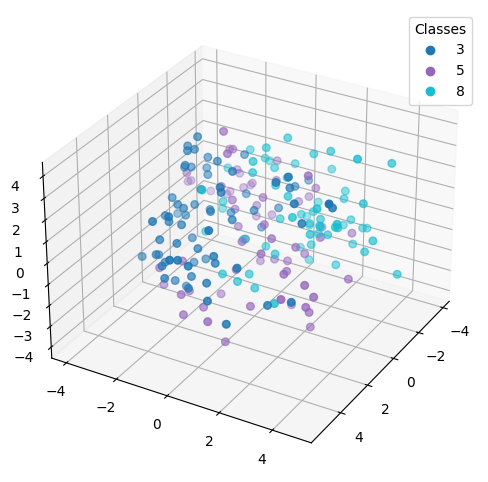

In [11]:
show_pca(test_data, classes=[3, 5, 8])

It should become clear that some samples of 3, 5 and 8 can easily be confused.

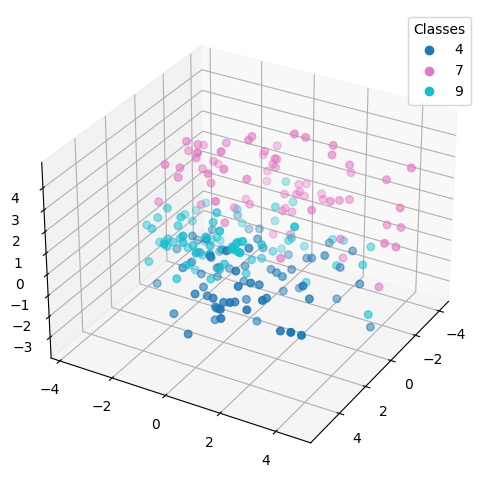

In [12]:
show_pca(test_data, classes=[4, 7, 9])

It should become clear that some samples of 4, 7 and 9 can easily be confused.

## Base Model

We use a ConvNet-like architecture with one or two convolution layers and one perceptron with a hidden layer.

### Big CNN

In [13]:
class BigCNN(nn.Module):
    def __init__(self, hidden_layer_dim=256):
        super().__init__()
        self.num_classes = 10
        self.features = nn.Sequential(
            # 1 input channel since this is a black-and-white image
            # 16 output channels = 2x2 x 2x2 (reduced two times by MaxPool2d)
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(28*28, hidden_layer_dim),
            nn.ReLU(),
            nn.Linear(hidden_layer_dim, self.num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        # Convert back logits to CPU for easier data manipulation
        return x.to('cpu')
    
big_model = BigCNN().to(device)

In [14]:
class BigRegularizedCNN(nn.Module):
    def __init__(self, hidden_layer_dim=256):
        super().__init__()
        self.num_classes = 10
        self.features = nn.Sequential(
            # 1 input channel since this is a black-and-white image
            # 16 output channels = 2x2 x 2x2 (reduced two times by MaxPool2d)
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(28*28, hidden_layer_dim),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_layer_dim, self.num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        # Convert back logits to CPU for easier data manipulation
        return x.to('cpu')

big_reg_model = BigRegularizedCNN().to(device)

### Small CNN

In [15]:
class SmallCNN(nn.Module):
    def __init__(self, hidden_layer_dim=64):
        super().__init__()
        self.num_classes = 10
        self.features = nn.Sequential(
            # 1 input channel since this is a black-and-white image
            # 4 output channels = 2x2 (reduced one time by MaxPool2d)
            nn.Conv2d(1, 4, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(4),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.1),
            nn.Linear(28*28, hidden_layer_dim),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_layer_dim, self.num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        # Convert back logits to CPU for easier data manipulation
        return x.to('cpu')

small_model = SmallCNN().to(device)

### Parameter info

In [16]:
big_model_summary = torchinfo.summary(big_model)
big_model_summary

Layer (type:depth-idx)                   Param #
BigCNN                                   --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       160
│    └─ReLU: 2-2                         --
│    └─MaxPool2d: 2-3                    --
│    └─Conv2d: 2-4                       2,320
│    └─ReLU: 2-5                         --
│    └─MaxPool2d: 2-6                    --
├─Sequential: 1-2                        --
│    └─Linear: 2-7                       200,960
│    └─ReLU: 2-8                         --
│    └─Linear: 2-9                       2,570
Total params: 206,010
Trainable params: 206,010
Non-trainable params: 0

In [17]:
big_reg_model_summary = torchinfo.summary(big_reg_model)
big_reg_model_summary

Layer (type:depth-idx)                   Param #
BigRegularizedCNN                        --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       160
│    └─ReLU: 2-2                         --
│    └─MaxPool2d: 2-3                    --
│    └─BatchNorm2d: 2-4                  32
│    └─Conv2d: 2-5                       2,320
│    └─ReLU: 2-6                         --
│    └─MaxPool2d: 2-7                    --
├─Sequential: 1-2                        --
│    └─Linear: 2-8                       200,960
│    └─ReLU: 2-9                         --
│    └─Dropout: 2-10                     --
│    └─Linear: 2-11                      2,570
Total params: 206,042
Trainable params: 206,042
Non-trainable params: 0

In [18]:
small_model_summary = torchinfo.summary(small_model)
small_model_summary

Layer (type:depth-idx)                   Param #
SmallCNN                                 --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       40
│    └─ReLU: 2-2                         --
│    └─MaxPool2d: 2-3                    --
│    └─BatchNorm2d: 2-4                  8
├─Sequential: 1-2                        --
│    └─Dropout: 2-5                      --
│    └─Linear: 2-6                       50,240
│    └─ReLU: 2-7                         --
│    └─Dropout: 2-8                      --
│    └─Linear: 2-9                       650
Total params: 50,938
Trainable params: 50,938
Non-trainable params: 0

In terms of parameter count, the `SmallCNN` model is 4 times smaller than `BigCNN`.

Note how the model dimensions here (50k-200k) are much higher than the input dimensions (784).

### Hyperparameters

These default hyperparameters are optimal for MNIST classification with our CNN architecture.

We use some of these parameters for the AdamW optimizer.

In [19]:
DEFAULT_HYPERPARAMETERS = dict(
    # Low learning rate is fine for AdamW. We want low variance in the results.
    learning_rate = 1e-3,
    # Regularization term for AdamW optimizer.
    weight_decay = 1e-2,
    # Note that the performance can with a larger batch size.
    batch_size = 64,
    # Make training time as short as possible.
    # This is fine since the dataset is large and features are easy to learn.
    epochs = 1
)
# We will use the same batch size in all this notebook.
batch_size = DEFAULT_HYPERPARAMETERS['batch_size']

### Loss function

The cross-entropy loss takes two arguments:
- the logits (unnormalized probabilites for each class)
- the true class

In [20]:
loss_fn = CrossEntropyLoss()

### Train / test loops

In [21]:

def train_loop(model, dataloader: DataLoader, loss_fn, optimizer, keep_pbars=True):
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()

    # Make a nice progress bar
    pbar = tqdm(desc='Train loop', total=len(dataloader.dataset), leave=keep_pbars)
    for X, y in dataloader:
        # Compute prediction and loss
        logits = model(X)
        loss = loss_fn(logits, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        pbar.n += len(X)
        pbar.set_postfix(loss=loss.item())
    pbar.close()
    if keep_pbars and pbar.disable:
        print(pbar)

def test_loop(model, dataloader: DataLoader, loss_fn, keep_pbars=False):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    test_loss, correct = 0, 0
    # Make a nice progress bar
    pbar = tqdm(desc='Test loop', total=len(dataloader.dataset), leave=keep_pbars)

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for i, (X, y) in enumerate(dataloader):
            logits = model(X)
            test_loss += loss_fn(logits, y).item()
            correct += (logits.argmax(1) == y).type(torch.float).sum().item()

            pbar.n += len(X)
            pbar.set_postfix(
                accuracy=(correct / pbar.n),
                avg_loss=(test_loss / (i + 1)),
            )
    pbar.close()
    if keep_pbars and pbar.disable:
        print(pbar)

def train_test_loop(
        model, train_dataloader, test_dataloader,
        loss_fn, hyperparams=DEFAULT_HYPERPARAMETERS,
        keep_pbars=True,
    ):
    """
    Run training and testing loop on the model.
    
    Similar to `keras.Model.compile`.
    """
    lr = hyperparams['learning_rate']
    weight_decay = hyperparams['weight_decay']
    epochs = hyperparams['epochs']
    # We use AdamW, which is one of the most popular optimizers in deep learning.
    # It converges faster than SGD and is more efficient.
    # However, its performance is also much more sensitive to hyperparameters and noise in the dataset.
    optimizer = AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    for _t in trange(epochs, desc='Train epochs', unit='epoch', postfix=hyperparams, leave=keep_pbars):
        train_loop(model, train_dataloader, loss_fn, optimizer, keep_pbars=keep_pbars)
        test_loop(model, test_dataloader, loss_fn, keep_pbars=keep_pbars)

In [22]:
# NOTE: the dataset is already shuffled.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

In [23]:
train_test_loop(big_model, train_dataloader, test_dataloader, loss_fn)

/home/lvt/.local/share/virtualenvs/ml-TQx6uCZG/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


100%|██████████| 10000/10000 [00:00<?, ?it/s]


In [24]:
train_test_loop(big_reg_model, train_dataloader, test_dataloader, loss_fn)

100%|██████████| 10000/10000 [00:00<?, ?it/s]


In [25]:
train_test_loop(small_model, train_dataloader, test_dataloader, loss_fn)

100%|██████████| 10000/10000 [00:00<?, ?it/s]


The bigger and the smaller model have comparable performance on the test set.

## CNN model introspection

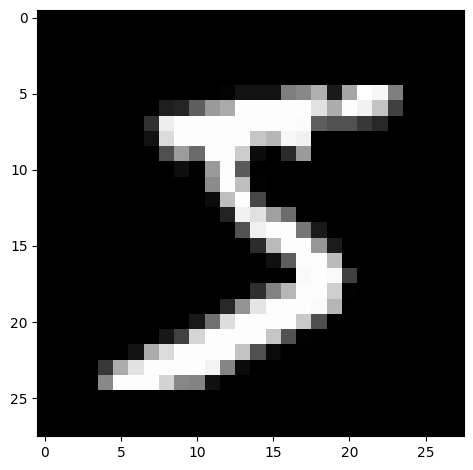

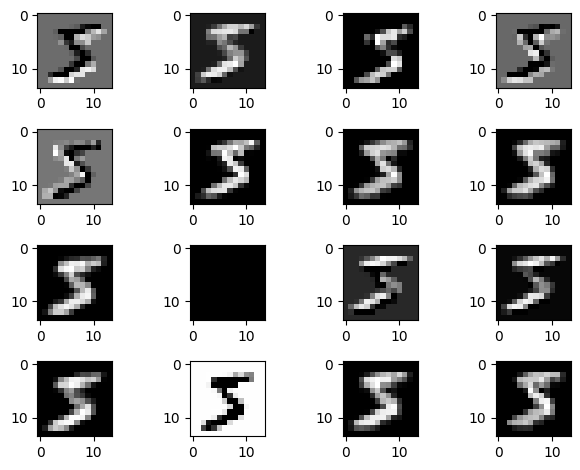

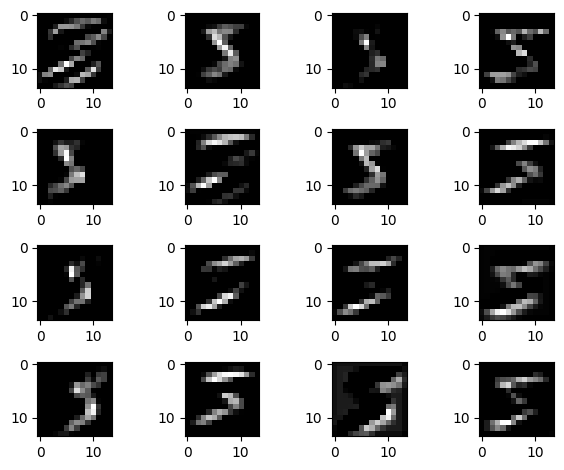

In [26]:
@torch._dynamo.disable
def input_hook(_module, input, _output):
    input = input[0].to('cpu').detach().flatten(0, 2)
    fig, ax = plt.subplots()
    ax.imshow(input, cmap=plt.cm.gray, interpolation='nearest')
    fig.tight_layout()

@torch._dynamo.disable
def conv_features_hook(_module, _input, output):
    features = torch.flatten(output, 0, 1).to('cpu').detach()
    fig = plt.figure()
    for i, feature in enumerate(features):
        ax = plt.subplot(4, 4, i + 1)
        ax.imshow(feature, cmap=plt.cm.gray, interpolation='nearest')
    fig.tight_layout()

handle0 = big_model.features.get_submodule('0').register_forward_hook(input_hook)
handle2 = big_model.features.get_submodule('2').register_forward_hook(conv_features_hook)
handle4 = big_model.features.get_submodule('4').register_forward_hook(conv_features_hook)

big_model(next(iter(DataLoader(training_data)))[0])
plt.tight_layout()

handle0.remove()
handle2.remove()
handle4.remove()

### Optimize model performance

In [27]:
# `torch.compile` improves performance by a factor of 2 after a few runs
# Also see https://pytorch.org/tutorials/intermediate/torch_compile_tutorial.html
big_model.compile()
big_reg_model.compile()
small_model = SmallCNN().to(device)
small_model.compile()

## Evaluation

In order to have a metric value per class, we use the F1-score.

### Batched model prediction

In [28]:
def labels_and_predictions(model, dataset: Dataset, as_logits=False):
    """
    Returns the dataset labels `y_true` and the model predictions `y_pred`.

    If `as_logits` is `False`, `y_pred` contains the predicted classes.
    Otherwise, `y_pred` contains the logits (unnormalized prediction values for each class).
    """
    model.eval()

    y_true = dataset.targets

    X, _ = next(iter(DataLoader(dataset, batch_size=len(dataset))))
    with torch.no_grad():
        y_pred = model(X)
    
    if not as_logits:
        y_pred = y_pred.argmax(1)
    return y_true, y_pred


In [29]:
def labels_and_predictions(model, dataset: Dataset, as_logits=False):
    """
    Returns the dataset labels `y_true` and the model predictions `y_pred`.

    If `as_logits` is `False`, `y_pred` contains the predicted classes.
    Otherwise, `y_pred` contains the logits (unnormalized prediction values for each class).
    """
    model.eval()
    
    y_true = dataset.targets

    loader = DataLoader(dataset, batch_size=batch_size)

    # Perform inference on batches and collect results in a single tensor
    # TODO: use torch.stack? problem with last batch which has different length
    with torch.no_grad():
        if not as_logits:
            y_pred = torch.zeros(len(dataset))
        else:
            Xb, _ = next(iter(loader))
            y = model(Xb[0:1])
            num_classes = y.shape[1]

            y_pred = torch.zeros((len(dataset), num_classes))
        
        i = 0
        for X, _ in loader:
            with torch.autocast(device_type=X.device.type):
                y_p = model(X).detach()
            if not as_logits:
                y_p = y_p.argmax(1)
            y_pred[i : i + len(y_p)] = y_p
            i += len(X)
    
    return y_true, y_pred

### Confusion matrix and F1-score

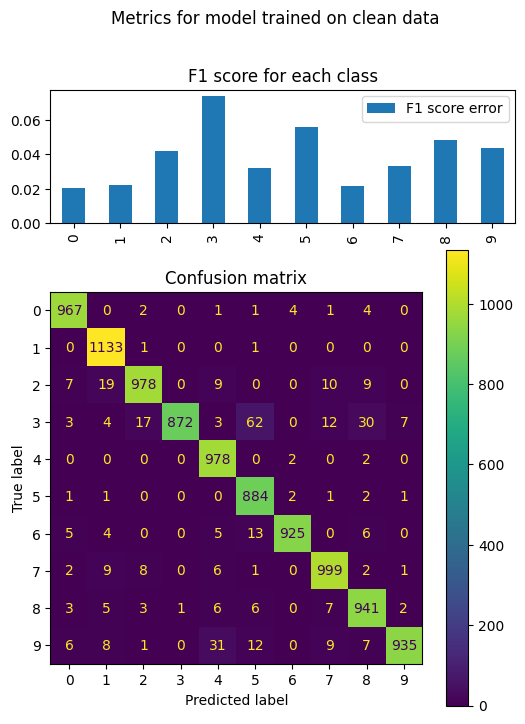

In [30]:
def show_metrics(model, dataset, fig=None, suptitle='Evaluation metrics'):
    y_true, y_pred = labels_and_predictions(model, dataset)
    f1_score_err = 1. - f1_score(y_true, y_pred, average=None)
    df = pd.DataFrame(data={'F1 score error': f1_score_err})

    if fig is None:
        fig = plt.figure(figsize=(6, 8))
    if suptitle:
        fig.suptitle(suptitle)
    gs = fig.add_gridspec(nrows=4, ncols=1)
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1:])
    ax1.set_title('F1 score for each class')
    ax2.set_title('Confusion matrix')

    df.plot.bar(y='F1 score error', ax=ax1)
    
    cm = confusion_matrix(y_true, y_pred)
    ConfusionMatrixDisplay(cm).plot(ax=ax2)
    return f1_score_err, cm


show_metrics(big_model, test_data, suptitle='Metrics for model trained on clean data');

### Display loss statistics by class

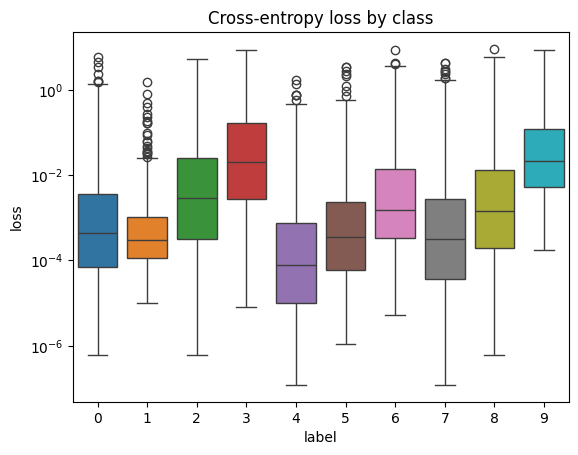

In [31]:
def display_loss(model, dataset, loss_fn):
    y_true, logits = labels_and_predictions(model, dataset, as_logits=True)
    df = pd.DataFrame({
        'label': y_true,
        'loss': loss_fn(logits, y_true),
    })
    sns.boxplot(df, x='label', y='loss', hue='label', legend=None, log_scale=(False, True), palette='tab10')

display_loss(big_model, test_data, CrossEntropyLoss(reduction='none'))
plt.title('Cross-entropy loss by class');

Promising candidates for label flipping include 9 and 3.

## Label flipping

### Flipping labels adversarially

This attack assumes we have access to the top-2 predictions of the classifier.

In [32]:
def most_frequent_confusions(y_true: Tensor, y_pred: Tensor) -> np.ndarray:
    """
    Returns the most frequent confusion for each class.

    # Parameters
    `y_pred` : `torch.Tensor`
        A batch of predicted labels.
    # Returns
    `confusions` : `numpy.ndarray`
        An array of same length as the number of classes.
    
    For each class `c1`, `confusions[c1]` is the most frequent other class
    that is predicted when the true class is `c1`.
    """
    cm = confusion_matrix(y_true, y_pred)
    np.fill_diagonal(cm, 0)
    return cm.argmax(axis=-1)

def most_frequent_second_predictions(y_logits: Tensor) -> np.ndarray:
    """
    Returns the most frequent second prediction after each class.

    # Parameters
    `y_logits` : `torch.Tensor`
        A batch of class logits
    # Returns
    `seconds` : an array of same length as the number of classes.
    For each class `c1`, `seconds[c1]` is the most frequent class `c2`
    such that the vector of top-2 predictions is `[c1, c2]`.
    """
    # Get the number of classes
    C = y_logits.shape[-1]

    # Get the top 2 predictions for each sample
    #np.argpartition(pred, kth=-2, axis=-1)[:, -2:]
    top2_preds = torch.topk(y_logits, k=2, axis=-1).indices

    # Encode top 2 predictions as a decimal number
    top2_preds_enc = C * top2_preds[:, 0] + top2_preds[:, 1]

    # Count the number of occurrences of each "top 2 prediction"
    pairs, counts = np.unique(top2_preds_enc, return_counts=True)

    # Sort by number of occurrences
    #count_sort_idx = np.argsort(-counts)
    #pairs = pairs[count_sort_idx]

    seconds = np.arange(C)
    seconds_counts = np.zeros(C, int)
    for (pair, count) in zip(pairs, counts):
        # Decode pair
        first, second = pair // C, pair % C
        if count > seconds_counts[first]:
            seconds[first] = second
            seconds_counts[first] = count
    return seconds

### Most frequent confusions

In [33]:
def show_most_frequent_confusions(model, dataset):
    y_true, y_pred = labels_and_predictions(model, dataset)

    cm = confusion_matrix(y_true, y_pred, normalize='true')
    np.fill_diagonal(cm, 0)
    df = pd.DataFrame({
        'Most frequently confused with': cm.argmax(axis=-1),
        'Percentage': 100.0 * cm.max(axis=-1),
    })
    df.index.name = 'Class'
    df.sort_values(by='Percentage', ascending=True)
    pd.options.display.float_format = '{:.2f}'.format
    print(df)

show_most_frequent_confusions(big_model, test_data)

       Most frequently confused with  Percentage
Class                                           
0                                  6        0.41
1                                  2        0.09
2                                  1        1.84
3                                  5        6.14
4                                  6        0.20
5                                  6        0.22
6                                  5        1.36
7                                  1        0.88
8                                  7        0.72
9                                  4        3.07


### Label-flipping `Dataset` wrapper

In [34]:
class LabelFlippedDataset(Dataset):
    """
    A custom dataset that flips the labels of a part of an original dataset.
    """

    def __init__(
            self,
            dataset: Dataset,
            flip_on: np.ndarray[bool],
            flip_table: dict = None,
            transform=None,
            target_transform=None,
        ):
        """
        Create a new `LabelFlippingDataset`.

        # Parameters
        - `dataset` : the original dataset
        - `flip_on` : an array of booleans that indicate the samples to be flipped
        - `flip_table` : a dictionary such that the label `l1` is replaced by `flip_table[l1]`.

        Only the labels that are keys of `flip_table` are altered,
        so `flip_table` does not need to be complete.
        
        If `flip_table` is `None`, we perform indiscriminate, untargeted label flipping.
        """

        self._dataset = dataset

        self.flip_on = flip_on
        self.flip_table = flip_table

        self.transform = transform
        self.target_transform = target_transform

        if self.flip_table is None:
            # Indiscriminate label flipping
            num_classes = len(dataset.classes)
            self.flipped_labels = torch.randint(num_classes, size=(len(dataset),))
        else:
            self.flipped_labels = dataset.targets.clone()
            # Only flip the labels as specified by the flip table
            for c1, c2 in self.flip_table.items():
                self.flipped_labels[dataset.targets == c1] = c2
    
    def __len__(self):
        return len(self._dataset)

    def __getitem__(self, index):
        X, y = self._dataset[index]
        if not self.flip_on[index]:
            # Return the original label
            return X, y
        # Return the flipped label
        y = self.flipped_labels[index]

        if self.transform:
            X = self.transform(X)
        if self.target_transform:
            y = self.target_transform(y)
        return X, y

    #TODO: __getitems__?

### Fit the label-flipping attack on the model predictions

In [35]:
from collections.abc import Mapping, Iterable

def make_label_flipped_data(
        base_model,
        dataset: Dataset,
        flip_proportion: float,
        targets: Mapping | Iterable = None,
        target_low_loss_criterion = None,
    ) -> LabelFlippedDataset:
    """
    Make a dataset with labels flipped according to the `base_model` confusions on `dataset`.

    # Parameters
    - `dataset` : the original dataset
    - `flip_proportion` : the proportion of the labels to be flipped
    - `targets` : dict or list-like, optional
        - If `targets` is a dictionary, then label `l1` is flipped with `flip_table[l1]`.
        - If `targets` is a list, then label `l1` is flipped with the most frequent other class that is predicted when the true class is `l1`.
        - If `targets` is `None`, we perform indiscriminate, untargeted label flipping.
    - `target_low_loss_criterion` : if specified, flip samples with lowest loss according to this criterion.
        This loss function must take two arguments: logits, target.
    """
    if isinstance(targets, Mapping):
        # Flipping pairs are explicitly specified.
        flip_table = targets
    elif isinstance(targets, Iterable):
        y_true, y_pred = labels_and_predictions(base_model, dataset)
        # For each target, flip with the label it is most confused with.
        flip_table = most_frequent_confusions(y_true, y_pred)
        flip_table = {c: flip_table[c] for c in targets}
    else:
        # Perform indiscriminate label flipping.
        flip_table = None
    
    fp = flip_proportion
    if target_low_loss_criterion is not None:
        # Flip samples with lowest loss according to this criterion
        
        y_true, logits = labels_and_predictions(base_model, dataset, as_logits=True)
        # Compute the loss for each sample
        loss = target_low_loss_criterion(logits, y_true)
        # Flip labels for samples with loss higher than this percentile        
        pivot = np.quantile(loss, fp, method='inverted_cdf')
        flip_on = (loss < pivot)

    else:
        # Take a random subset of the dataset
        flip_on = np.random.choice([False, True], size=len(dataset), p=[1. - fp, fp])

    return LabelFlippedDataset(
        dataset,
        flip_on=flip_on,
        flip_table=flip_table,
    )

## Results

### Train a new victim from scratch on the poisoned dataset

In [36]:
def label_flipping_attack(
        base_model, victim,
        training_data, test_data,
        flip_proportion, targets, target_low_loss_criterion=None,
        hyperparams=DEFAULT_HYPERPARAMETERS,
    ):
    """
    Create a poisoned dataset via label flipping based on the logits of a base model,
    train a victim model on this poisoned data, and return the trained model.
    """
    # Make a poisoned dataset with a label-flipping attack tuned on a base model
    poisoned_data = make_label_flipped_data(
        base_model,
        training_data,
        flip_proportion=flip_proportion,
        targets=targets,
        target_low_loss_criterion=target_low_loss_criterion,
    )
    print(f'Inspecting dataset after label flipping (proportion: {flip_proportion})')
    print('\tFlip table:', poisoned_data.flip_table)
    print('\tClass weights:', class_weights(poisoned_data))
    # Train the victim on the poisoned dataset and evaluate it on a clean test dataset
    train_loader = DataLoader(poisoned_data, batch_size=batch_size)
    test_loader = DataLoader(test_data, batch_size=batch_size)

    train_test_loop(
        victim, train_loader, test_loader,
        loss_fn, hyperparams, keep_pbars=False,
    )
    return victim

In [37]:
def label_flipping_attack_comparison(
        base_model,
        victim,
        training_data=training_data,
        test_data=test_data,
        targets=None,
        flip_proportions=[0.2, 0.5],
        target_low_loss_criterion=None,
        hyperparams=DEFAULT_HYPERPARAMETERS,
        title='',
    ):
    victim: nn.Module = victim.to(device)
    inital_state = victim.state_dict()

    nrows = (len(flip_proportions) + 1) // 2
    fig = plt.figure(layout='constrained', figsize=(10, 6 * nrows))
    fig.suptitle(title)
    subfigs = fig.subfigures(nrows, 2, wspace=0.07)

    for fp, fig in zip(flip_proportions, subfigs.flatten()):
        # Reset the neural network at each iteration
        victim.load_state_dict(inital_state)
        victim = label_flipping_attack(
            base_model,
            victim,
            training_data,
            test_data,
            flip_proportion=fp,
            targets=targets,
            target_low_loss_criterion=target_low_loss_criterion,
            hyperparams=hyperparams,
        )
        show_metrics(victim, test_data, fig=fig, suptitle=f'Label flipping proportion: {fp}')

### Indiscriminate label flipping

Inspecting dataset after label flipping (proportion: 0.1)
	Flip table: None
	Class weights: (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([5964, 6696, 5946, 6085, 5895, 5477, 5883, 6236, 5856, 5962]))
Inspecting dataset after label flipping (proportion: 0.4)
	Flip table: None
	Class weights: (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([5956, 6368, 5891, 6082, 5866, 5736, 6089, 6119, 5889, 6004]))


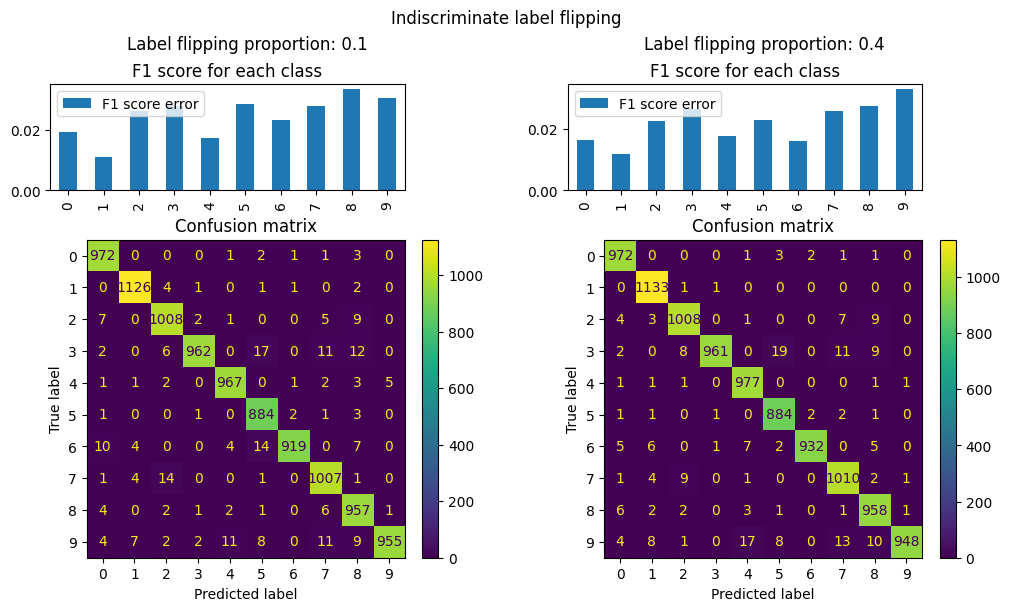

In [38]:
label_flipping_attack_comparison(
    base_model=big_model,
    victim=BigCNN(),
    flip_proportions=[0.1, 0.4],
    targets=None,
    title=f'Indiscriminate label flipping',
)

**A surprising result here!**

The model's performance remains surprisingly good against untargeted label flipping. This result can be attributed to two factors:
- The label noise is mostly eliminated by AdamW's quick convergence and regularization effect
- Since untargeted label flipping is unbiased (i.e the class weights are not affected and no label is favored in the predictions), the model is unlikely to overfit to the noise.

Changing our point of view to adversarial learning: noisy labels might be a good way to improve model resilience against targeted data poisoning.

In particular, **noisy labels act as a form of output layer regularization**. Thus, we may apply our existing intuition from the `Dropout` layer: noisy labels are useful when the model is overfitting.

Inspecting dataset after label flipping (proportion: 0.0)
	Flip table: None
	Class weights: (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]))
Inspecting dataset after label flipping (proportion: 0.4)
	Flip table: None
	Class weights: (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([5997, 6487, 6026, 6082, 5868, 5600, 6013, 6082, 5896, 5949]))


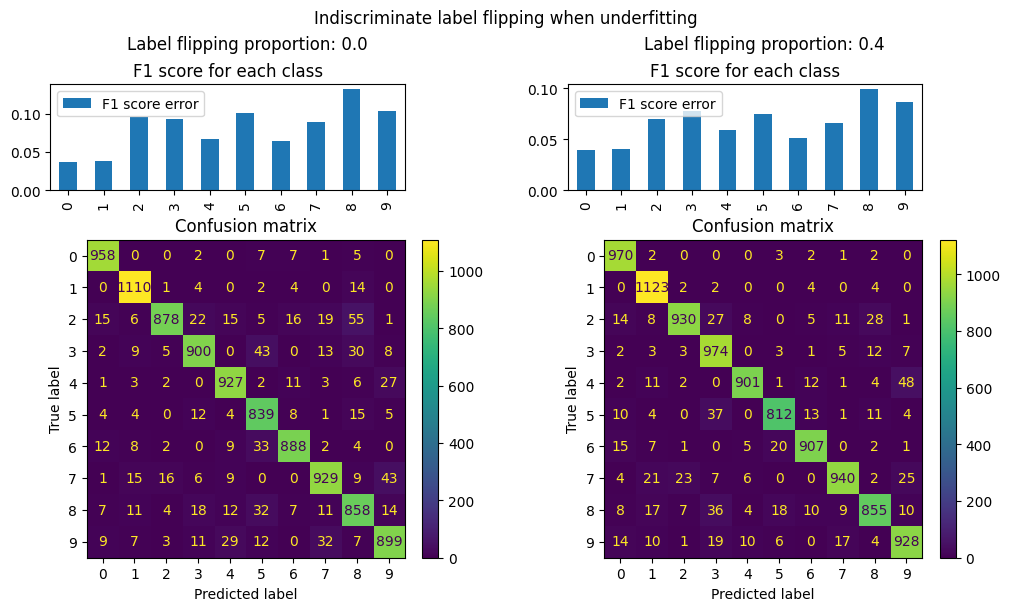

In [39]:
label_flipping_attack_comparison(
    base_model=big_model,
    victim=BigCNN(),
    flip_proportions=[0.0, 0.4],
    targets=None,
    hyperparams={**DEFAULT_HYPERPARAMETERS, 'learning_rate': 1e-4},
    title='Indiscriminate label flipping when underfitting',
)

Surprisingly, indiscriminate label flipping did not hurt the global performance of the model at all, even with 40 % poisoning rate. This wouldn't be the case when using an optimizer such as SGD which performs worse than AdamW.
TODO: do this comparison

However, the confusions might be concentrated towards the most frequent errors (the confusion matrix becomes sparser).
This is an interesting property for stealthy, targeted poisoning attacks.


Inspecting dataset after label flipping (proportion: 0.0)
	Flip table: None
	Class weights: (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]))
Inspecting dataset after label flipping (proportion: 0.4)
	Flip table: None
	Class weights: (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([5950, 6403, 5941, 6135, 5799, 5512, 5930, 6196, 6077, 6057]))


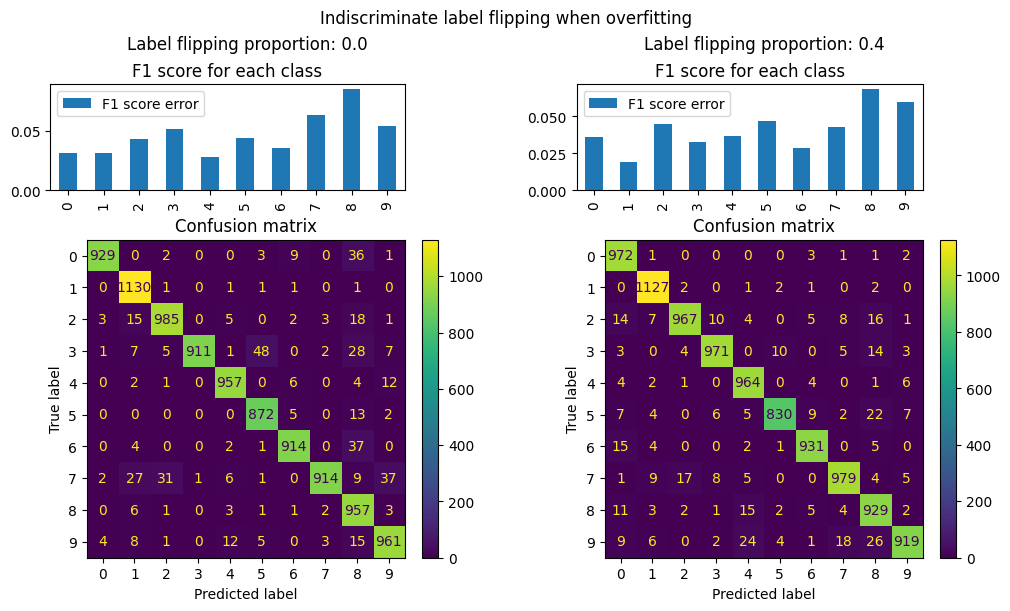

In [40]:
label_flipping_attack_comparison(
    base_model=big_model,
    victim=BigCNN(),
    flip_proportions=[0.0, 0.4],
    targets=None,
    hyperparams={**DEFAULT_HYPERPARAMETERS, 'learning_rate': 1e-2},
    title='Indiscriminate label flipping when overfitting',
)

When the model is overfitting, the effect of label flipping is reversed:
- the global performance is unchanged
- the performance on individual labels is made more homogeneous
- the confusion matrix is less sparse, which means the model makes more many small errors but less many large errors

**Conclusion:**
- When overfitting, noisy labels help removing bias towards some errors in the model predictions
- When underfitting, noisy labels improve performance on most cases, at the cost of amplifying the highest errors. The remaining located errors could be mitigated via machine unlearning for instance.

This can be seen as a case of the _no free lunch_ theorem in optimization.

#### The influence of flip proportion on performance

We use F1-score for each class as our performance criterion.

In [41]:
def f1_score_on_label_flipping(
        base_model,
        victim,
        training_data,
        test_data,
        flip_proportion: float,
        targets: list | dict | None,
        target_low_loss_criterion=None,
        hyperparams=DEFAULT_HYPERPARAMETERS,
    ) -> np.ndarray:
    """
    Perform a label-flipping attack
    and return the F1-score on the test dataset for each class.
    """
    # Make a poisoned dataset with a label-flipping attack tuned on a base model
    poisoned_data = make_label_flipped_data(
        base_model,
        training_data,
        flip_proportion=flip_proportion,
        targets=targets,
        target_low_loss_criterion=target_low_loss_criterion,
    )
    train_loader = DataLoader(poisoned_data, batch_size=batch_size)
    test_loader = DataLoader(test_data, batch_size=batch_size)
    train_test_loop(
        victim, train_loader, test_loader,
        loss_fn, hyperparams=hyperparams, keep_pbars=False,
    )
    y_true, y_pred = labels_and_predictions(victim, test_data)
    return f1_score(y_true, y_pred, average=None)

In [42]:
def compute_f1_fp_values(
        base_model,
        victim,
        training_data,
        test_data,
        flip_proportion: np.ndarray,
        rounds: int,
        targets: list | dict = None,
        target_low_loss_criterion=None,
        hyperparams=DEFAULT_HYPERPARAMETERS,
    ) -> pd.DataFrame:
    """
    Perform many label-flipping attacks varying the flip proportion,
    and for each attack, compute the F1-scores of each class on the test dataset.

    # Parameters
    - `base_model` : a trained model to tune the attack on.
    - `victim` : a (usually untrained) model to be trained on a poisoned dataset.
    - `flip_proportion` : an array of poisoning rates to use for the attacks.
    - `targets` : the labels to target for label flipping. If set to `None`, an untargeted attack is performed.
    - `rounds` : The number of runs to repeat the attack.
    A higher number of rounds give more precise information on the distribution of the F1-scores.
    - `target_low_loss_criterion` : see `make_label_flipped_data`.

    # Returns
    A dataframe of all the attacks with the parameters specified in the columns:
    `class`, `flip_proportion`, `f1_score`, `round`.
    """
    victim = victim.to(device)
    victim.compile()
    initial_state = victim.state_dict()

    f1_scores = []
    for fp in tqdm(flip_proportion, desc='Flip proportion', leave=False):
        # We perform many rounds since indiscriminate label flipping is random
        for r in trange(
                rounds,
                desc='Computing F1 score',
                unit='round',
                leave=False,
            ):
            # Reset the model parameters
            victim.load_state_dict(initial_state)

            score = f1_score_on_label_flipping(
                base_model,
                victim,
                training_data,
                test_data,
                flip_proportion=fp,
                targets=targets,
                target_low_loss_criterion=target_low_loss_criterion,
                hyperparams=hyperparams,
            )
            for (c, score) in enumerate(score):
                f1_scores.append([c, fp, score, r])
    return pd.DataFrame(
        f1_scores,
        columns=['class', 'flip_proportion', 'f1_score', 'round'],
    )

In [43]:
def plot_f1_fp_curve(
    base_model,
    victim,
    training_data=training_data,
    test_data=test_data,
    flip_proportion: np.ndarray = None,
    rounds: int = 2,
    targets: list | dict = None,
    target_low_loss_criterion=None,
    hyperparams=DEFAULT_HYPERPARAMETERS,
    title='',
):
    """
    See `compute_f1_fp_values` for documentation over the parameters.
    """
    if flip_proportion is None:
        flip_proportion = np.linspace(0.0, 0.5, 6)
    
    f1_scores = compute_f1_fp_values(
        base_model, victim,
        training_data, test_data,
        flip_proportion, rounds, targets,
        target_low_loss_criterion, hyperparams,
    )
    g = sns.pointplot(
        data=f1_scores,
        x='flip_proportion',
        y='f1_score',
        hue='class',
        palette='tab10',
    )
    g.set_xlabel('Proportion of flipped labels')
    g.set_ylabel(f'F1 score (averaged over {rounds} rounds)')
    # Forces rounding on xticks
    g.xaxis.set_ticklabels([
        plt.Text(t._x, t._y, f'{float(t._text):.3g}')
        for t in g.xaxis.get_ticklabels()
    ])
    g.set_title(title)
    return f1_scores, g

/tmp/ipykernel_28000/515361724.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.xaxis.set_ticklabels([


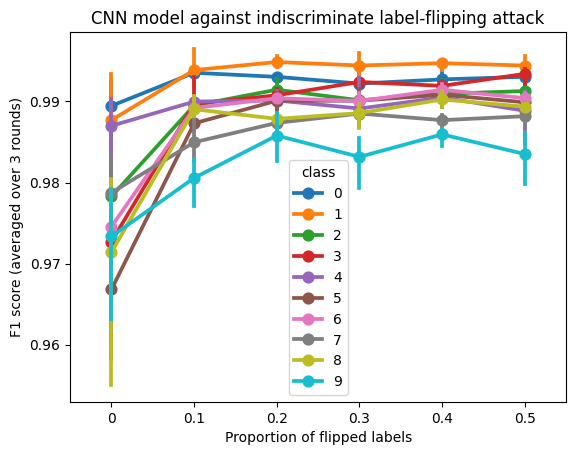

In [44]:
plot_f1_fp_curve(
    base_model=big_model,
    victim=BigCNN(),
    targets=None,
    rounds=3,
    title='CNN model against indiscriminate label-flipping attack',
);

Except for very high poisoning rates (> 80 %), the model performance remains exceedingly high.

This showcases the efficiency of techniques such as **noisy labels learning** (this technique), label smoothing (see below). Even if the data is not pointwise correct, the model manages to perform well via internal majority vote.

In [45]:
CrossEntropyLoss(label_smoothing=0.1)

CrossEntropyLoss()

Another approach is to introduce noise on the input features instead of the output labels, for instance with [randomized smoothing](https://arxiv.org/abs/2002.03018).

### Targeted label swapping

Label swapping is interesting since it preserves class weights. In the following experiments, we analyze the effect of swapping on only two classes.

Unfortunately, the confusion matrix is not symmetric, so choosing the swapped pair based on the highest confusion coefficient (3 and 5) may not be the best strategy.

Instead, we target classes which have the closest internal representation in the network. From the PCA, classes 9 and 7 look promising.

We choose to analyze the effect of label swapping with proportion $r < 0.5$. Indeed, label swapping with $r > 0.5$ is symmetrical with $1 - r$.

Inspecting dataset after label flipping (proportion: 0.15)
	Flip table: {9: 7, 7: 9}
	Class weights: (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6257, 5851, 5957]))
Inspecting dataset after label flipping (proportion: 0.2)
	Flip table: {9: 7, 7: 9}
	Class weights: (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6134, 5851, 6080]))
Inspecting dataset after label flipping (proportion: 0.25)
	Flip table: {9: 7, 7: 9}
	Class weights: (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6209, 5851, 6005]))
Inspecting dataset after label flipping (proportion: 0.4)
	Flip table: {9: 7, 7: 9}
	Class weights: (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6084, 5851, 6130]))


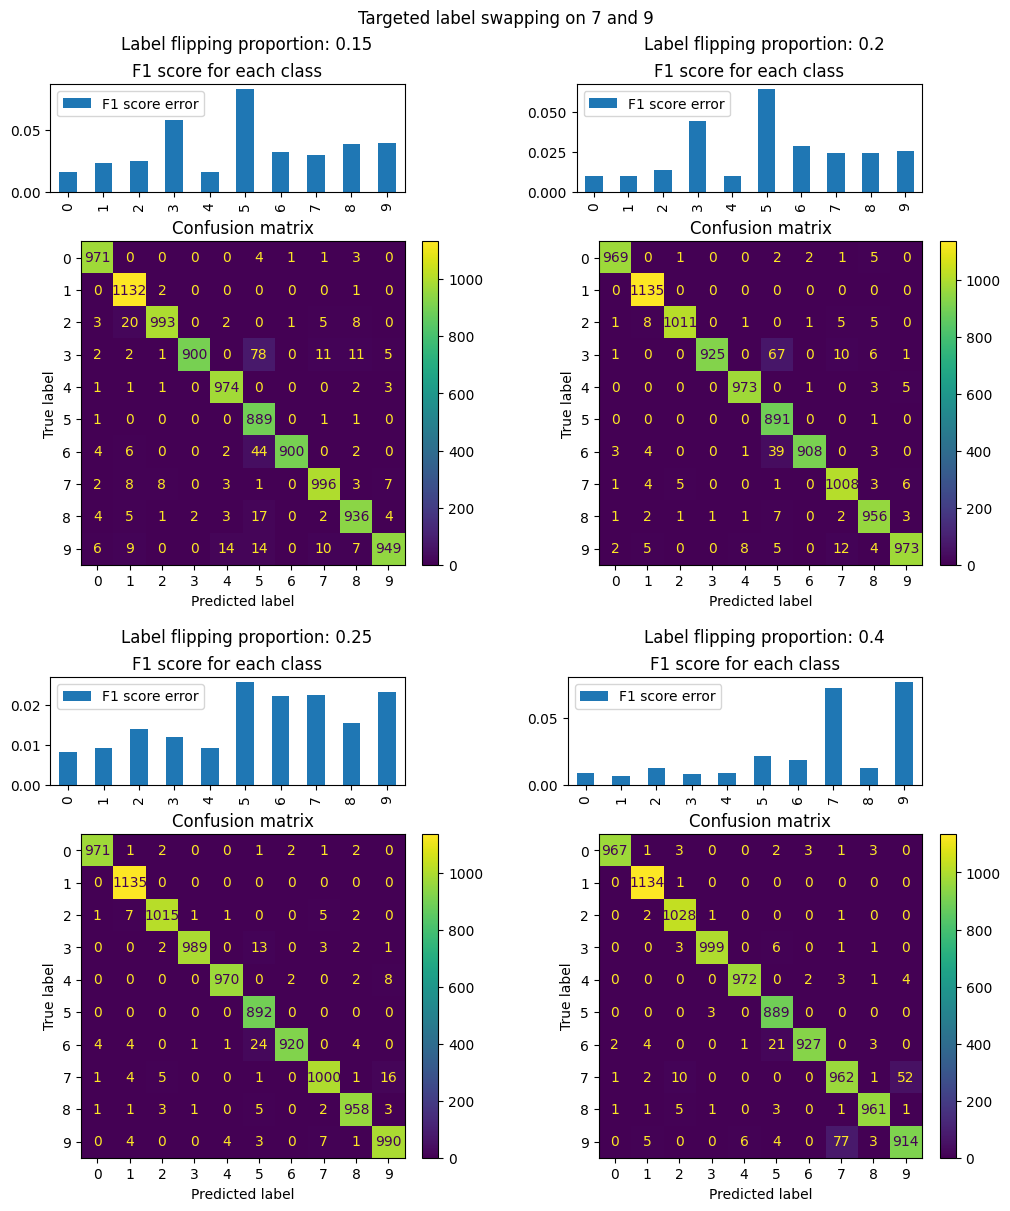

In [46]:
label_flipping_attack_comparison(
    base_model=big_model,
    victim=BigCNN(),
    flip_proportions=[0.15, 0.2, 0.25, 0.4],
    targets={9: 7, 7: 9},
    title='Targeted label swapping on 7 and 9',
);

**Observations:**

- Under $r \ge 0.2$, the effect of label swapping is very small, similar to indiscriminate label flipping. Note that there is no symmetry between 7 and 9 in the confusion matrix.
- Surprisingly between $0.2 < r < 0.25$ the confusion between 7 and 9 gets reversed.
- Unexpectedly, with $r \ge 0.25$ the model suddenly confuses 3 with 5 again.

**Conclusion:** empirically, targeted label swapping can have an effect on untargeted classes. We may conjecture that label swapping affects the internal representation of 7 and 9, so the orthogonality between classes is also distorted.

/tmp/ipykernel_28000/515361724.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.xaxis.set_ticklabels([


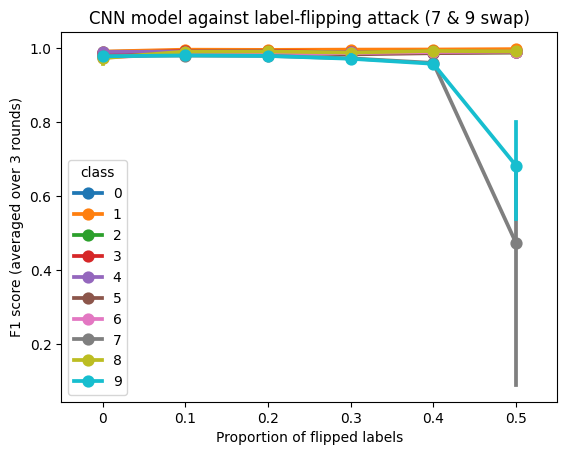

In [47]:
plot_f1_fp_curve(
    base_model=big_model,
    victim=BigCNN(),
    flip_proportion=np.linspace(0.0, 0.5, 6),
    targets={7: 9, 9: 7},
    rounds=3,
    title='CNN model against label-flipping attack (7 & 9 swap)',
);

Observation: the accuracy quicly drops around 40 % since the model cannot decide of the true label by majority vote anymore. However the performance numbers are very unpredictable.

### Swapping two highly orthogonal features

Below we perform label swapping on two classes that are very different: 0 and 1.

TODO: measure orthogonality (inspect model: explainability, forward hook)

/tmp/ipykernel_28000/515361724.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.xaxis.set_ticklabels([


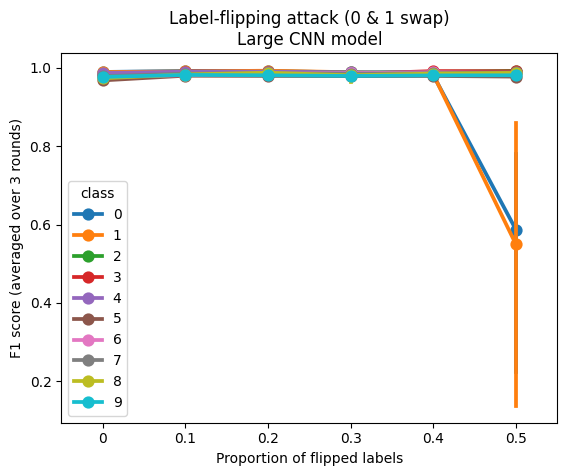

In [48]:
plot_f1_fp_curve(
    base_model=big_model,
    victim=BigCNN(),
    flip_proportion=np.linspace(0.0, 0.5, 6),
    targets={0: 1, 1: 0},
    rounds=3,
    title='Label-flipping attack (0 & 1 swap)\nLarge CNN model',
);

Since 0 and 1 are easily distinguishable, the model resists well with $r \le 0.3$.

### Swapping more than 2 classes

We swap labels in a circular permutation: 0 -> 1 -> ... -> 9 -> 0.

/tmp/ipykernel_28000/515361724.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.xaxis.set_ticklabels([


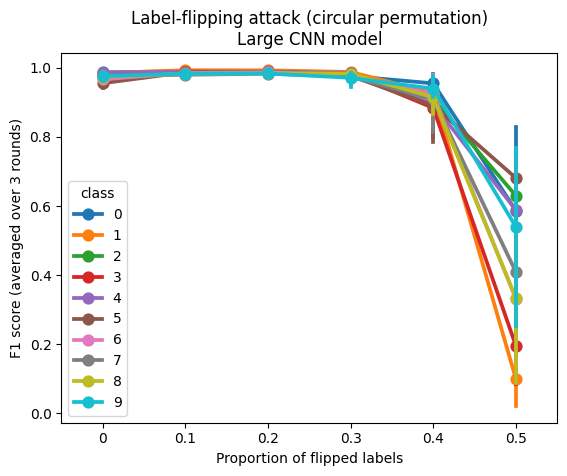

In [49]:
fp = np.linspace(0.0, 0.5, 6)
plot_f1_fp_curve(
    base_model=big_model,
    victim=BigCNN(),
    flip_proportion=fp,
    targets={i: (i + 1) % 10 for i in range(10)},
    rounds=3,
    title='Label-flipping attack (circular permutation)\nLarge CNN model',
);

Circular label flipping biases the model and affects all of the model's internal representations of each classes. This translates into an earlier performance drop between $0.2 < r < 0.3$.

### Targeted label-flipping on low-loss samples

/tmp/ipykernel_28000/515361724.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.xaxis.set_ticklabels([


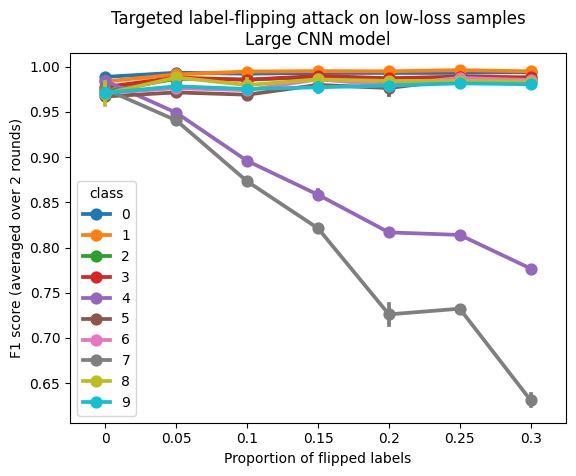

In [50]:
plot_f1_fp_curve(
    base_model=big_model,
    victim=BigCNN(),
    flip_proportion=np.linspace(0.0, 0.3, 7),
    targets=[7, 9],
    target_low_loss_criterion=CrossEntropyLoss(reduction='none'),
    rounds=2,
    title='Targeted label-flipping attack on low-loss samples\nLarge CNN model',
);

Targeting samples with low loss is an efficient strategy. The model accuracy quicly drops within $0 < r < 0.1$.

/tmp/ipykernel_28000/515361724.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.xaxis.set_ticklabels([


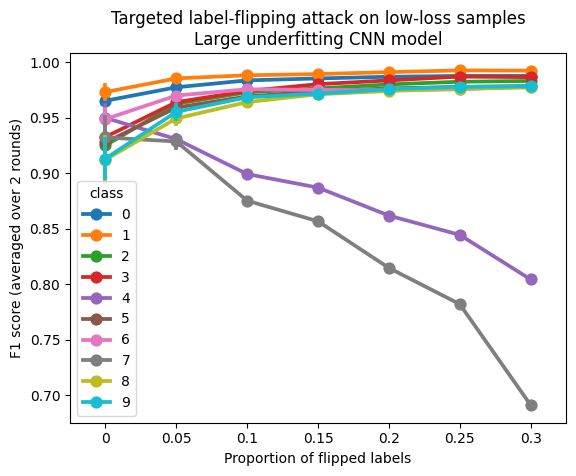

In [51]:
plot_f1_fp_curve(
    base_model=big_model,
    victim=BigCNN(),
    flip_proportion=np.linspace(0.0, 0.3, 7),
    targets=[7, 9],
    target_low_loss_criterion=CrossEntropyLoss(reduction='none'),
    rounds=2,
    hyperparams={**DEFAULT_HYPERPARAMETERS, 'learning_rate': 1e-4},
    title='Targeted label-flipping attack on low-loss samples\nLarge underfitting CNN model',
);

/tmp/ipykernel_28000/515361724.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.xaxis.set_ticklabels([


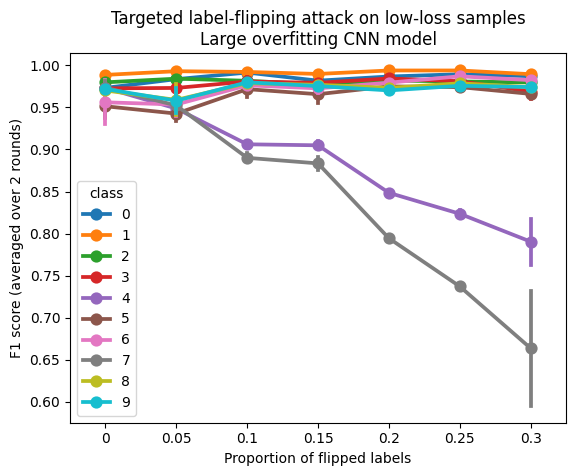

In [52]:
plot_f1_fp_curve(
    base_model=big_model,
    victim=BigCNN(),
    flip_proportion=np.linspace(0.0, 0.3, 7),
    targets=[7, 9],
    target_low_loss_criterion=CrossEntropyLoss(reduction='none'),
    rounds=2,
    hyperparams={**DEFAULT_HYPERPARAMETERS, 'learning_rate': 1e-2},
    title='Targeted label-flipping attack on low-loss samples\nLarge overfitting CNN model',
);

**Choosing the wrong learning rate causes underfitting or overfitting, which can harm the model's performance on targeted attacks.**

### Targeted label flipping on a regularized model

This regularized model has a batch normalization layer and a dropout layer.

/tmp/ipykernel_28000/515361724.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.xaxis.set_ticklabels([


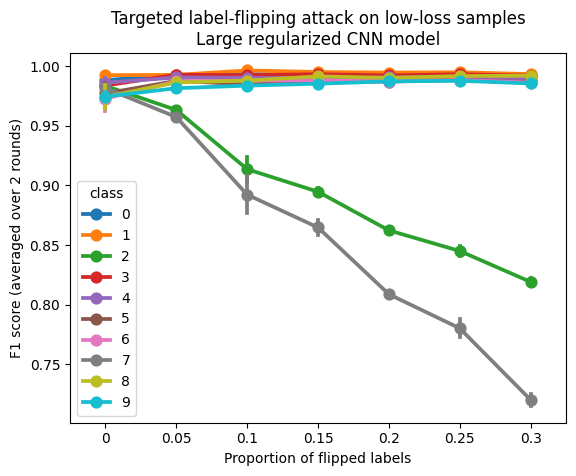

In [53]:
plot_f1_fp_curve(
    base_model=big_reg_model,
    victim=BigRegularizedCNN(),
    flip_proportion=np.linspace(0.0, 0.3, 7),
    targets=[7, 9],
    target_low_loss_criterion=CrossEntropyLoss(reduction='none'),
    rounds=2,
    title='Targeted label-flipping attack on low-loss samples\nLarge regularized CNN model',
);

### Targeted label flipping on a smaller model

/tmp/ipykernel_28000/515361724.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.xaxis.set_ticklabels([


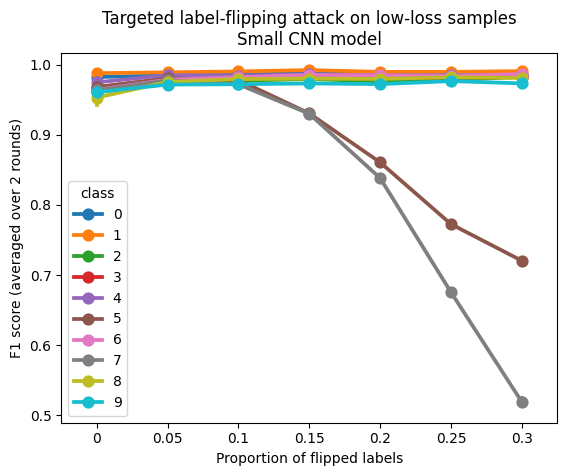

In [54]:
plot_f1_fp_curve(
    base_model=small_model,
    victim=SmallCNN(),
    flip_proportion=np.linspace(0.0, 0.3, 7),
    targets=[7, 9],
    target_low_loss_criterion=CrossEntropyLoss(reduction='none'),
    rounds=2,
    title='Targeted label-flipping attack on low-loss samples\nSmall CNN model',
);

Smaller models and regularized models resist targeted label flipping extremely well: the performance remains roughly constant even with high poisoning rates. Since their performance are almost on par with the bigger model, the main difference is thir ability to resist overfitting.

**Vulnerability to targeted attacks is correlated to the ability to overfit.**

**Relevant topics:** data amplification, bias.

## The impact of model dimension

Below we study the impact of the model dimension (number of trainable parameters) on its performance against label flipping.

We perform a circular permutation of the labels under different poisoning rates between 0 % and 50 %. Even if the optimal attack strongly depends on the model dimension, using the same attack makes it easer to compare the performances of every victim model.

In [55]:
def compute_f1_fp_dim_values(
        victims,
        training_data=training_data,
        test_data=test_data,
        flip_proportion: np.ndarray = None,
        rounds: int | list = 2,
        targets: list | dict = None,
        target_low_loss_criterion=None,
        hyperparams=DEFAULT_HYPERPARAMETERS,
    ):
    """
    Execute `compute_f1_fp_values` on each victim and combine the results
    into a new dataframe, adding the column `num_params` equal to the number
    of trainable parameters for each victim results.
    """
    if flip_proportion is None:
        flip_proportion = np.linspace(0.0, 0.5, 6)
    
    f1_scores = []
    i = 0
    for victim in tqdm(victims, desc='Victims', leave=False):
        base_model = deepcopy(victim).to(device)
        train_test_loop(
            base_model,
            DataLoader(training_data, batch_size=batch_size),
            DataLoader(test_data, batch_size=batch_size),
            loss_fn, hyperparams,
            keep_pbars=False,
        )
        if hasattr(rounds, '__len__'):
            rnds = rounds[i]
        else:
            rnds = rounds
        indiv_f1_scores = compute_f1_fp_values(
            base_model, victim,
            training_data, test_data,
            flip_proportion, rnds, targets,
            target_low_loss_criterion, hyperparams,
        )
        indiv_f1_scores['num_params'] = torchinfo.summary(victim).trainable_params
        f1_scores.append(indiv_f1_scores)
        i += 1
    return pd.concat(f1_scores)

In [56]:
def plot_f1_fp_dim_curves(
        f1_scores: pd.DataFrame,
        classes: list,
        title='Targeted label flipping',
    ):
    flip_proportion = f1_scores['flip_proportion'].unique()
    flip_proportion.sort()

    nrows = (len(flip_proportion) + 1) // 2
    fig, axes = plt.subplots(nrows=nrows, ncols=2)
    fig.set_figwidth(10)
    fig.set_figheight(5 * nrows)
    fig.suptitle(title)

    for (fp, ax) in zip(flip_proportion, axes.flatten()):
        df = f1_scores[
            (f1_scores['flip_proportion'] == fp)
            & (f1_scores['class'].isin(classes))
        ]
        # Geometric mean over each class F1 score
        df['f1_score'] = np.log(df['f1_score'])
        df = df.groupby('num_params', as_index=False)['f1_score'].mean()
        df['f1_score'] = np.exp(df['f1_score'])
        g = sns.pointplot(
            data=df,
            x='num_params',
            y='f1_score',
            #hue='class',
            #palette='tab10',
            ax=ax,
            log_scale=(True, False),
            native_scale=True,
        )
        g.set_xlabel('Model dimension (number of parameters)')
        g.set_ylabel('F1 score (geomean across classes)')
        g.set_title(f'{round(100 * fp)} % label flipping')

    fig.tight_layout()

### Performance results for larger models

In [57]:
f1_scores_1 = compute_f1_fp_dim_values(
    victims=[
        BigCNN(hidden_layer_dim=dim)
        for dim in [8, 12, 16, 24, 32, 48, 64, 96, 128, 192, 256, 512, 1024]
    ],
    training_data=training_data,
    test_data=test_data,
    flip_proportion=np.linspace(0.0, 0.5, 6),
    rounds=[5, 4, 3, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    targets={i: (i + 1) % 10 for i in range(10)},
    target_low_loss_criterion=CrossEntropyLoss(reduction='none'),
)

W1227 12:01:49.672000 28000 torch/_dynamo/convert_frame.py:844] [0/8] torch._dynamo hit config.cache_size_limit (8)
W1227 12:01:49.672000 28000 torch/_dynamo/convert_frame.py:844] [0/8]    function: 'forward' (/tmp/ipykernel_28000/2483854026.py:21)
W1227 12:01:49.672000 28000 torch/_dynamo/convert_frame.py:844] [0/8]    last reason: 0/0: GLOBAL_STATE changed: grad_mode 
W1227 12:01:49.672000 28000 torch/_dynamo/convert_frame.py:844] [0/8] To log all recompilation reasons, use TORCH_LOGS="recompiles".
W1227 12:01:49.672000 28000 torch/_dynamo/convert_frame.py:844] [0/8] To diagnose recompilation issues, see https://pytorch.org/docs/main/torch.compiler_troubleshooting.html.


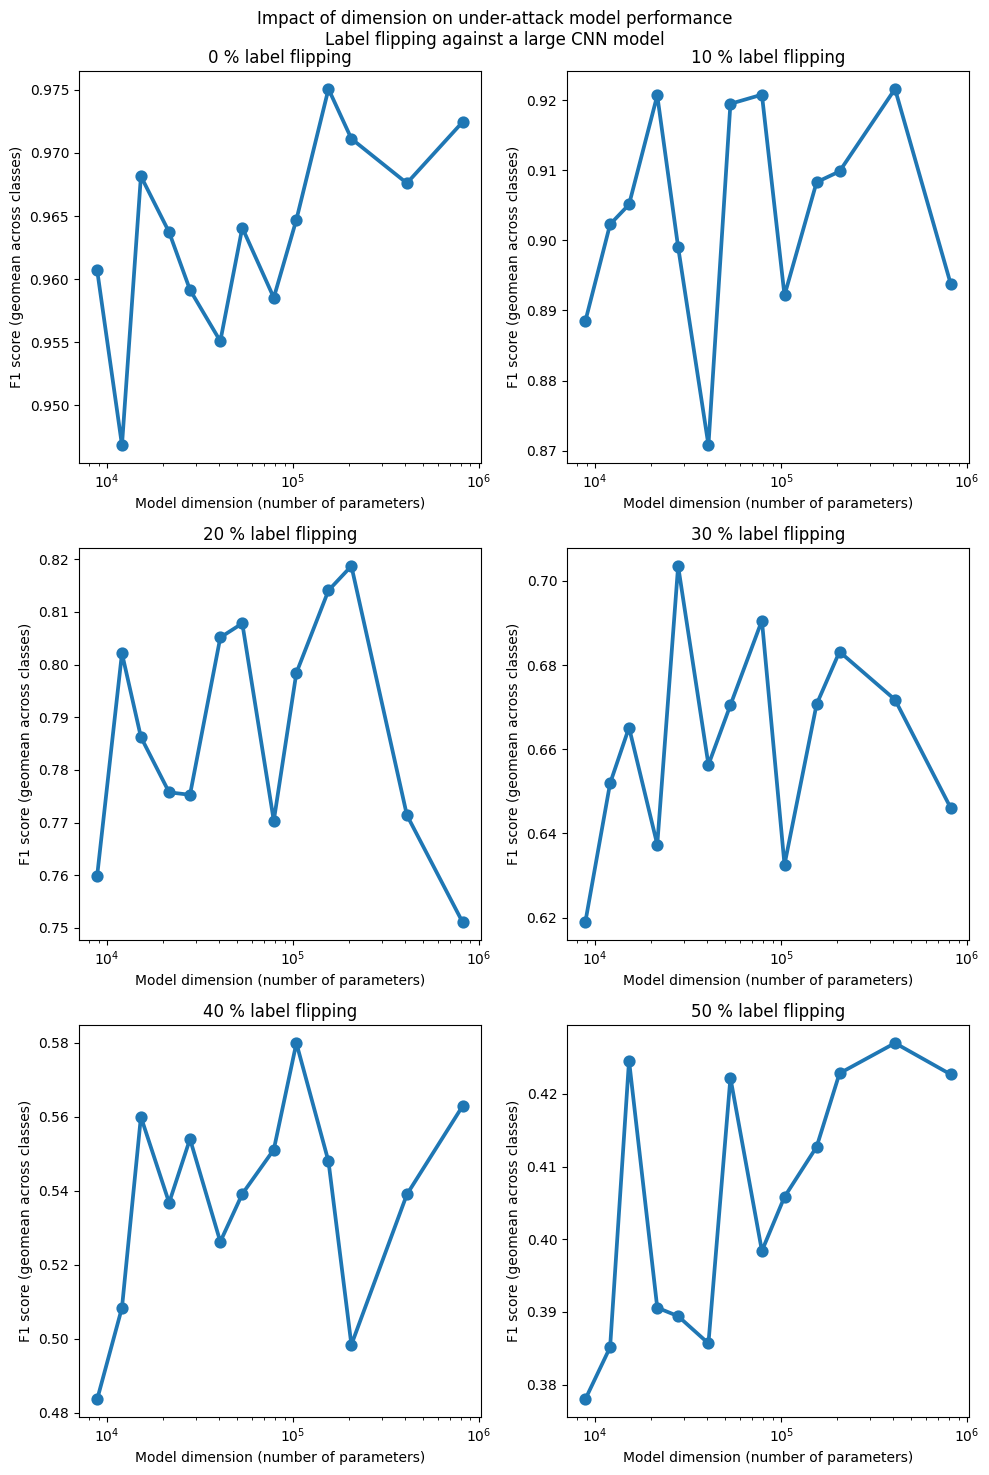

In [58]:
plot_f1_fp_dim_curves(
    f1_scores_1,
    classes=list(range(10)),
    title='Impact of dimension on under-attack model performance\n'
          'Label flipping against a large CNN model',
);

The model performance oscillates with the number of parameters. Note that the y-axis bounds and scales differ between all of these diagrams, and the x-axis is logarithmic.

There are three main patterns here:
- With no data poisoning, the model performance increases logarithmically with the number of parameters. We can infer that the regularizing effect of the optimizer (`AdamW(weight_decay=...)`) prevents performance drop due to overfitting.
- With low data poisoning rates (10 % - 30 %), the model performance increases slightly and then sharply drops after a certain point
- With high data poisoning rates (> 30 %), the model performance is much lower so a higher number of parameters seem to increase the performance further.

### Performance results for smaller models

In [59]:
f1_scores_2 = compute_f1_fp_dim_values(
    victims=[
        SmallCNN(hidden_layer_dim=dim)
        for dim in [8, 12, 16, 24, 32, 48, 64]
    ],
    training_data=training_data,
    test_data=test_data,
    flip_proportion=np.linspace(0.0, 0.5, 6),
    rounds=[5, 4, 3, 2, 1, 1, 1],
    targets={i: (i + 1) % 10 for i in range(10)},
    target_low_loss_criterion=CrossEntropyLoss(reduction='none'),
)

W1227 12:09:43.520000 28000 torch/_dynamo/convert_frame.py:844] [2/8] torch._dynamo hit config.cache_size_limit (8)
W1227 12:09:43.520000 28000 torch/_dynamo/convert_frame.py:844] [2/8]    function: 'forward' (/tmp/ipykernel_28000/2449234718.py:21)
W1227 12:09:43.520000 28000 torch/_dynamo/convert_frame.py:844] [2/8]    last reason: 2/0: GLOBAL_STATE changed: grad_mode 
W1227 12:09:43.520000 28000 torch/_dynamo/convert_frame.py:844] [2/8] To log all recompilation reasons, use TORCH_LOGS="recompiles".
W1227 12:09:43.520000 28000 torch/_dynamo/convert_frame.py:844] [2/8] To diagnose recompilation issues, see https://pytorch.org/docs/main/torch.compiler_troubleshooting.html.


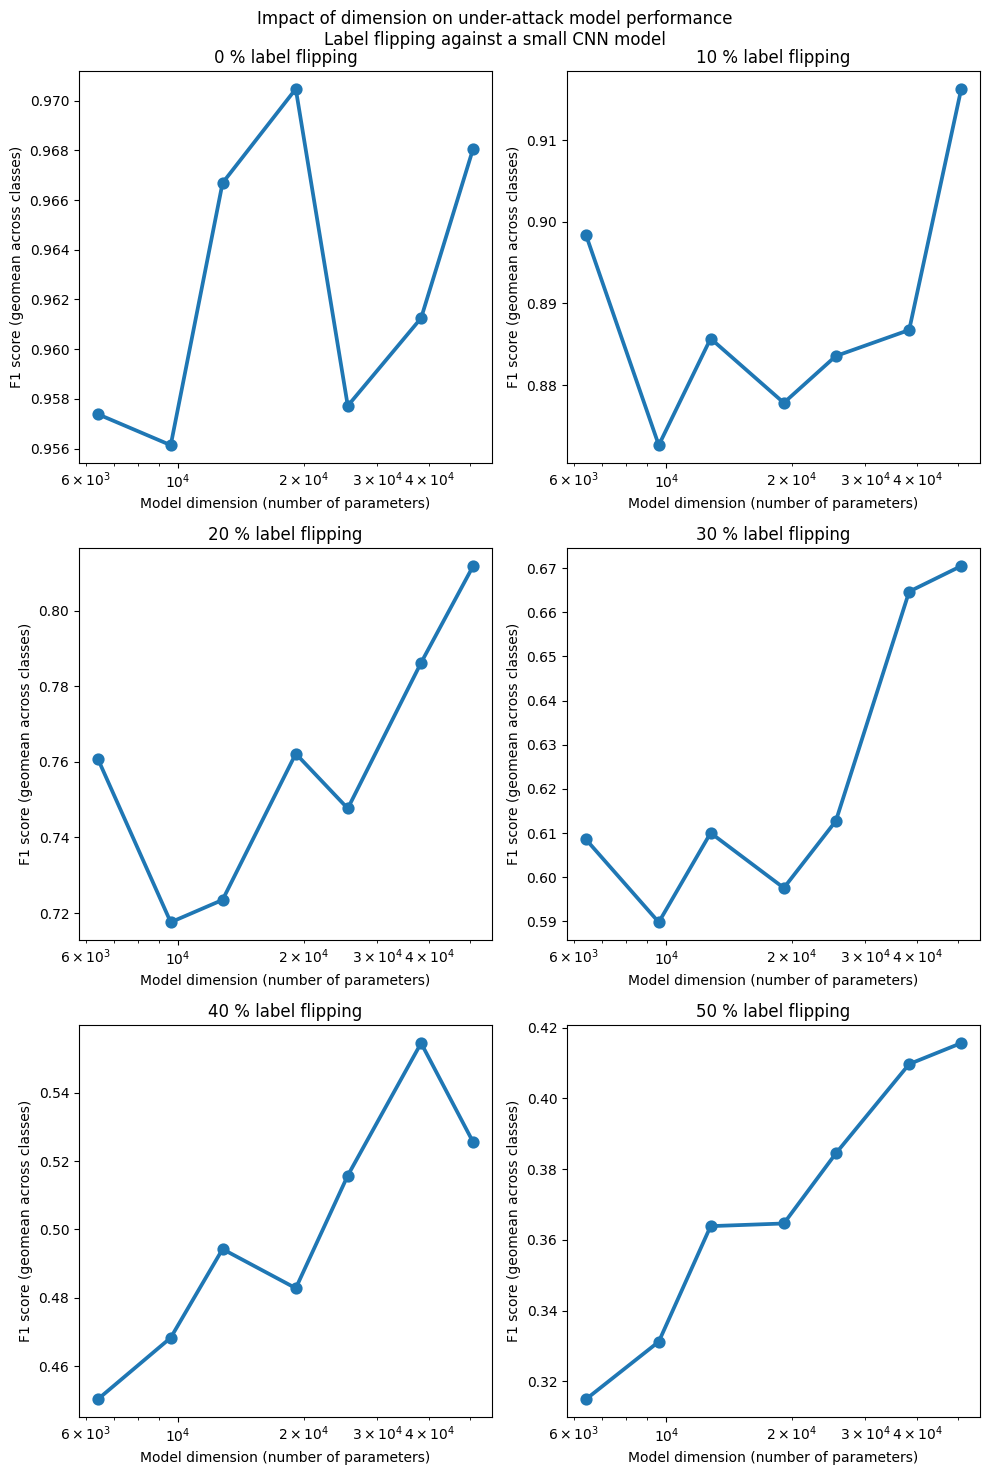

In [60]:
plot_f1_fp_dim_curves(
    f1_scores_2,
    classes=list(range(10)),
    title='Impact of dimension on under-attack model performance\n'
          'Label flipping against a small CNN model',
);

The trend is clearer here (note that `SmallCNN` benefits from slight regularization).

With low poisoning rates (10 - 20 %), the model performance first decreases, before reaching a local minima around 25000 parameters, then sharply increases. This is in line with our previous conclusions that larger models can benefit from noisy labels. The difference here is that the noise introduced here by label flipping is non-uniform and biased.

## Label flipping on fine-tuning

Finally, we consider a different threat model. The victim first pretrains a model on a clean dataset. Afterwards, the attacker performs a label-flipping attack on a second, smaller dataset. Finally, the victim fine-tunes the pretrained model on this poisoned dataset.

TODO: try with another optimizer and smaller models with/out regularization

### Initial pre-training

In [61]:
pretrained = BigCNN().to(device)

# First, pre-train the model on a large clean dataset for a "long" time period
train_test_loop(
    pretrained, train_dataloader, test_dataloader,
    loss_fn,
    keep_pbars=False,
)

### Finetuning attack

We emulate finetuning by training on a smaller dataset with a lower learning rate.

We assume the attacker can poison 100 % of the fine-tuning dataset. This scenario gives the most convincing results, as we will see later.

In [62]:
def finetuning_train_test_split(dataset: Dataset, finetuning_size: int):
    finetuning_data = TensorDataset(*dataset[:finetuning_size])
    finetuning_data.targets = finetuning_data.tensors[1]

    # We should not test the model on any data is has already been trained on
    test_data = TensorDataset(*dataset[finetuning_size:])
    test_data.targets = test_data.tensors[1]

    return finetuning_data, test_data


def finetuning_attack(pretrained_model, finetuning_size, learning_rate, targets):
    # We use the test dataset for finetuning since it is disjoint from the train dataset
    finetuning_data, test_data2 = finetuning_train_test_split(test_data, finetuning_size)

    hyperparams = DEFAULT_HYPERPARAMETERS.copy()
    # Perform some "fine-tuning" on poisoned data
    hyperparams['learning_rate'] = learning_rate

    return label_flipping_attack(
        base_model=pretrained_model,
        victim=deepcopy(pretrained_model),
        training_data=finetuning_data,
        test_data=test_data2,
        flip_proportion=1.0,
        targets=targets,
        hyperparams=hyperparams,
    )

### Results

/tmp/ipykernel_28000/515361724.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.xaxis.set_ticklabels([


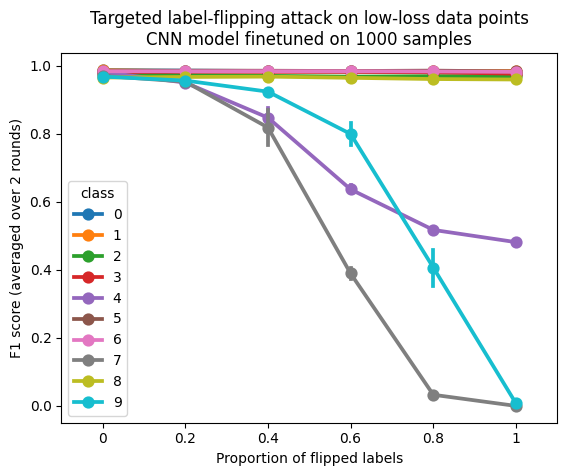

In [63]:
finetuning_size = 1000
finetuning_data, test_data2 = finetuning_train_test_split(test_data, finetuning_size=finetuning_size)

hyperparams = DEFAULT_HYPERPARAMETERS.copy()
# Use a lower rate than the one used for pretraining
hyperparams['learning_rate'] = 2e-4

plot_f1_fp_curve(
    pretrained,
    victim=deepcopy(pretrained),
    training_data=finetuning_data,
    test_data=test_data2,
    flip_proportion=np.linspace(0.0, 1.0, 6),
    rounds=2,
    targets={7: 4, 9: 4},
    target_low_loss_criterion=CrossEntropyLoss(reduction='none'),
    hyperparams=hyperparams,
    title=f'Targeted label-flipping attack on low-loss data points\n'
          f'CNN model finetuned on {finetuning_size} samples'
);

Even when the model has been pretrained before, label flipping can harm its performance in very few iterations.

1000 samples that are 100 % flipped are enough to reduce the model performance to zero on the targets.

#### Difference with federated learning

Consider an adversary who has access to a small proportion of the training process. Generally, the gradient updates of all contributors are interleaved, so the effect of data poisoning here might be overwritten by the other trustworthy participants.

However, if an adversary has some sort of "monopoly" on a specific label, the model performance can be destroyed on this target.

In comparison, fine-tuning is always performed after pretraining, which gives to the adversary the freedom to significantly harm the model performance, even with small datasets.

## Key takeaways

### Optimizer

The optimizer parameters can have a huge impact on underfitting or overfitting.
Thus carefully choosing learning rate can significantly mitigate the impacts of label flipping.

This is particularly true for optimizers with slow convergence (SGD) and optimizers that are sensitive to their parameters (AdamW).

### Untargeted vs targeted

- Convolutional neural networks have a good resilience to mild, indiscriminate label flipping
- Targeted label flipping on some classes has a stronger impact than indiscriminate label flipping
- Targeting low-loss data points does a good job at confusing the model with low poisoning rates.

### Accuracy against poisoning rate

With low poisoning rates, the accuracy drop is approximately linear to the proportion of flipped labels.
However, the model performance can drop sharply around 40 - 50 %, in unpredictable ways. Sometimes, a label can be entirely eliminated from the model predictions!

### Model size and regularization

The ability to overfit is correlated to the vulnerability to data poisoning.
Thus, models should have an appropriate number of parameters, with sufficient regularization in order to avoid overfitting.

Regularization can be achieved on other components :
- the optimizer (via weight decay)
- the output layer (via label smoothing)
- the loss function (via robust mini-batch gradient aggregation)

### Fine-tuning

Even small tasks such as fine-tuning can have a huge impact on the model parameters, especially if the attacker has complete access to the fine-tuning dataset.
In a way, the attacker could inject poisoned batches without "interference" from legitimate data.
In the context of cybersecurity, this is a hint that the whole pipeline must be secured, from the data to the inference time.